In [1]:
# Import statements
import json
import numpy as np
import matplotlib as mtplb
import matplotlib.pyplot as plt
import skimage.io as skio
import scipy
import skimage as sk

<h1>Part 1</h1>

In [2]:
# Open the images
hailey = skio.imread("../images/hailey.jpg")
george = skio.imread("../images/george.jpg")

# Opening JSON file
f = open('hailey_george.json',)
   
# returns JSON object as 
# a dictionary
data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

assert(len(im1_points) == len(im2_points))
   
# Closing file
f.close()

In [3]:
# Compute the mean of the two point sets
mean_points = np.add(im1_points, im2_points)/2
# print(mean_points)
x = np.take(mean_points, 0, axis=1)
y = np.take(mean_points, 1, axis=1)

In [4]:
# print(x)
# print(y)

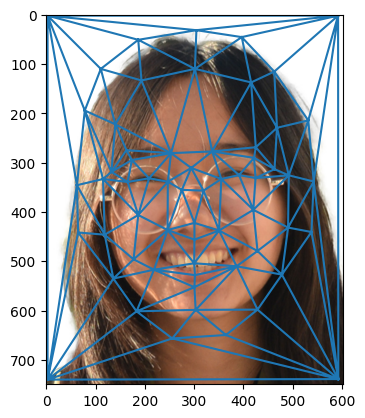

In [5]:
# Create triangulation on the images
triangulation = mtplb.tri.Triangulation(x, y)
triangles = triangulation.triangles

plt.triplot(triangulation)
plt.gca().invert_yaxis()

plt.imshow(hailey)

In [6]:
# print(triangles)

In [7]:
# Get the triangles of the correspondence points in im1 and im2
im1_x = np.take(im1_points, 0, axis=1)
im1_y = np.take(im1_points, 1, axis=1)
im1_triangulation = mtplb.tri.Triangulation(im1_x, im1_y)
im1_triangles = im1_triangulation.triangles

im2_x = np.take(im2_points, 0, axis=1)
im2_y = np.take(im2_points, 1, axis=1)
im2_triangulation = mtplb.tri.Triangulation(im2_x, im2_y)
im2_triangles = im2_triangulation.triangles

<h1>Part 2</h1>

In [8]:
def computeAffine(tri1_pts, tri2_pts):
    # Create a matrix for the triangles that contains the x,y vals of each vertice
        # | ax ay 1 |
        # | bx by 1 |
        # | cx cy 1 |
    a = np.matrix([tri1_pts[0], tri1_pts[1], np.ones(3)]).T
    b = np.matrix([tri2_pts[0], tri2_pts[1], np.ones(3)]).T
    # print(a.shape, b.shape)
    # print(a)
    # print(b)
    return np.linalg.solve(b, a)

In [9]:
for t in np.arange(0, 1, 0.1):
    # Compute the avg shape/triangles
    avg_shape = np.add(((1 - t) * im1_points), (t * im2_points))
    avg_x = np.take(avg_shape, 0, axis=1)
    avg_y = np.take(avg_shape, 1, axis=1)
    avg_triangulation = mtplb.tri.Triangulation(avg_x, avg_y)
    avg_triangles = avg_triangulation.triangles

    # Transform the triangles from img -> avg shape
    for i in range(len(im1_triangles)):
        im1_tri = im1_triangles[i]
        im2_tri = im2_triangles[i]
        avg_tri = avg_triangles[i]

        # Get the indicies of the vertices
        im1_a, im1_b, im1_c = im1_tri[0], im1_tri[1], im1_tri[2]
        im2_a, im2_b, im2_c = im2_tri[0], im2_tri[1], im2_tri[2]
        avg_a, avg_b, avg_c = avg_tri[0], avg_tri[1], avg_tri[2]

        # Compute Affine transformations
        im1_tri_pts = [np.array([im1_points[im1_a][0], im1_points[im1_b][0], im1_points[im1_c][0]]), np.array([im1_points[im1_a][1], im1_points[im1_b][1], im1_points[im1_c][1]])]
        im2_tri_pts = [np.array([im2_points[im2_a][0], im2_points[im2_b][0], im2_points[im2_c][0]]), np.array([im2_points[im2_a][1], im2_points[im2_b][1], im2_points[im2_c][1]])]
        avg_tri_pts = [np.array([avg_shape[avg_a][0], avg_shape[avg_b][0], avg_shape[avg_c][0]]), np.array([avg_shape[avg_a][1], avg_shape[avg_b][1], avg_shape[avg_c][1]])]

        im1_avg_aff = computeAffine(im1_tri_pts, avg_tri_pts)
        im2_avg_aff = computeAffine(im2_tri_pts, avg_tri_pts)

        # print("im1")
        # print(im1_avg_aff.shape)
        # print(im1_avg_aff)

        # print("im2")
        # print(im2_avg_aff.shape)
        # print(im2_avg_aff)

        # Create the polygon
        polygon = sk.draw.polygon([avg_shape[avg_a][0], avg_shape[avg_b][0], avg_shape[avg_c][0]], [avg_shape[avg_a][1], avg_shape[avg_b][1], avg_shape[avg_c][1]])
        polygon_matrix = np.matrix([polygon[0], polygon[1], np.ones(len(polygon[0]))]).T

        # Multiply the polygon with the inverse affine transform matrix
        im1_inv_warp = np.dot(polygon_matrix, im1_avg_aff)
        im2_inv_warp = np.dot(polygon_matrix, im2_avg_aff)

        # print(im1_inv_warp.shape)
        # print(im1_inv_warp)
    
        # im1_interp = scipy.interpolate.griddata(im1_points, (hailey[:0], hailey[:1]), np.dot(im1_avg_aff[i], avg_shape))
        # plt.imshow(im1_interp)

#     plt.triplot(avg_triangulation)
# plt.gca().invert_yaxis()

    # assert(len(triangles) == len(avg_triangles))
    # for i in range(len(triangles)):
        # Affine warp the triangle in the triangulation from the original images into this avg triangle
        # A = computeAffine(triangles[i], avg_triangles[i])

        # For each pixel in the triangle, find the corresponding points in each image and set value to
        # weighted average (crossdissolve each triangle)

        # Add frame to sequence
        # seq.append()

        # ...

<h1>Part 3</h1>